# Pre-processing

In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [384]:
#import effecting factors
cdf = pd.read_csv('correlation.csv')
cdf['Date'] = pd.to_datetime(cdf['Date'])

print(cdf.info())
print(cdf.describe())
print(cdf.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           48 non-null     datetime64[ns]
 1   Year           48 non-null     int64         
 2   Month          48 non-null     int64         
 3   Price - Large  48 non-null     float64       
 4   Price - Small  48 non-null     float64       
 5   CCPI           48 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 2.4 KB
None
                      Date         Year      Month  Price - Large  \
count                   48    48.000000  48.000000      48.000000   
mean   2022-12-16 05:00:00  2022.500000   6.500000     108.404167   
min    2021-01-01 00:00:00  2021.000000   1.000000      85.000000   
25%    2021-12-24 06:00:00  2021.750000   3.750000      93.122500   
50%    2022-12-16 12:00:00  2022.500000   6.500000     109.065000   
75

In [385]:
#import sales volume data
df1 = pd.read_csv('coconut_oil_daily_sales_data.csv')
df = df1[df1['Year'] != 2025] #use values only before 2025
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ItemName     1461 non-null   object 
 1   RateN        1461 non-null   float64
 2   Date         1461 non-null   object 
 3   Month        1461 non-null   int64  
 4   Day          1461 non-null   int64  
 5   Year         1461 non-null   int64  
 6   AQty         1461 non-null   int64  
 7   Area         1461 non-null   object 
 8   VoucherType  1461 non-null   object 
 9   Total        1461 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 114.3+ KB
None
             RateN        Month          Day         Year         AQty  \
count  1461.000000  1461.000000  1461.000000  1461.000000  1461.000000   
mean    827.898357     6.522930    15.729637  2022.501027   121.170431   
std      75.108955     3.449884     8.803105     1.118723    39.105552   
min     704.700000     1

In [386]:
#create column to merge on
df['date_month'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)
cdf['date_month'] = cdf['Month'].astype(str) + '-' + cdf['Year'].astype(str)
print(df.info())
print(cdf.info())
print(df.head())
print(cdf.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ItemName     1461 non-null   object 
 1   RateN        1461 non-null   float64
 2   Date         1461 non-null   object 
 3   Month        1461 non-null   int64  
 4   Day          1461 non-null   int64  
 5   Year         1461 non-null   int64  
 6   AQty         1461 non-null   int64  
 7   Area         1461 non-null   object 
 8   VoucherType  1461 non-null   object 
 9   Total        1461 non-null   float64
 10  date_month   1461 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 125.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           48 non-null     datetime64[ns]
 1   Year           48 

In [387]:
#verifying if data is only of coconut oil sales in colombo
print(df['ItemName'].unique())
print(df['Area'].unique())

#percentage of negative values (returns)
print(df.shape)
negatives = (df['AQty'] < 0).sum()
value_count = (df['AQty'].count())
neg_perc = ((negatives/value_count)*100)

#print no. of useless rows
num_rows = (df['AQty'] == 0).sum()
num_perc = ((num_rows/value_count)*100)
print(num_rows)
print("Empty Qty:",num_perc.round(2),"%")

print((df['AQty'] < 0).sum())
print("negatives percentage:",neg_perc.round(2),"%")

['Coconut Oil 1 Ltr']
['Greater Colombo']
(1461, 11)
0
Empty Qty: 0.0 %
0
negatives percentage: 0.0 %


In [388]:
#Keeping only necessary columns and rows
df = df[df['AQty'] > 0].drop(["ItemName", "Day", "Area", "VoucherType", "Total"], axis=1)
print((df['AQty'] == 0).sum())
print(df.info())
print(df.head())

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RateN       1461 non-null   float64
 1   Date        1461 non-null   object 
 2   Month       1461 non-null   int64  
 3   Year        1461 non-null   int64  
 4   AQty        1461 non-null   int64  
 5   date_month  1461 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 68.6+ KB
None
   RateN      Date  Month  Year  AQty date_month
0  800.0  1/1/2021      1  2021    87     1-2021
1  802.5  1/2/2021      1  2021   103     1-2021
2  799.8  1/3/2021      1  2021    93     1-2021
3  797.2  1/4/2021      1  2021    97     1-2021
4  794.9  1/5/2021      1  2021   116     1-2021


In [389]:
#making sure only one record per date
new_df = df.groupby('Date').agg({
    'RateN': 'mean',
    'AQty': 'sum',
    'Year': 'first',
    'Month': 'first',
    'date_month': 'first'
}).reset_index()

# Convert 'Date' to datetime
new_df['Date'] = pd.to_datetime(new_df['Date'])

# Sort by date in ascending order
new_df = new_df.sort_values(by='Date').reset_index(drop=True)

print(new_df.info())
print(new_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1461 non-null   datetime64[ns]
 1   RateN       1461 non-null   float64       
 2   AQty        1461 non-null   int64         
 3   Year        1461 non-null   int64         
 4   Month       1461 non-null   int64         
 5   date_month  1461 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 68.6+ KB
None
        Date  RateN  AQty  Year  Month date_month
0 2021-01-01  800.0    87  2021      1     1-2021
1 2021-01-02  802.5   103  2021      1     1-2021
2 2021-01-03  799.8    93  2021      1     1-2021
3 2021-01-04  797.2    97  2021      1     1-2021
4 2021-01-05  794.9   116  2021      1     1-2021


In [390]:
#merge datasets into one
final_df = new_df.merge(cdf, on='date_month', how='left', suffixes=('', '_cdf'))
final_df = final_df.drop(columns=['Date_cdf','Year_cdf', 'Month_cdf'])
print("Date range:",df['Date'].min(),"-",df['Date'].max())
final_df.info()
final_df

Date range: 1/1/2021 - 9/9/2024
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1461 non-null   datetime64[ns]
 1   RateN          1461 non-null   float64       
 2   AQty           1461 non-null   int64         
 3   Year           1461 non-null   int64         
 4   Month          1461 non-null   int64         
 5   date_month     1461 non-null   object        
 6   Price - Large  1461 non-null   float64       
 7   Price - Small  1461 non-null   float64       
 8   CCPI           1461 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 102.9+ KB


,Date,RateN,AQty,Year,Month,date_month,Price - Large,Price - Small,CCPI
0,2021-01-01,800.0,87,2021,1,1-2021,102.5,85.0,119.9
1,2021-01-02,802.5,103,2021,1,1-2021,102.5,85.0,119.9
2,2021-01-03,799.8,93,2021,1,1-2021,102.5,85.0,119.9
3,2021-01-04,797.2,97,2021,1,1-2021,102.5,85.0,119.9
4,2021-01-05,794.9,116,2021,1,1-2021,102.5,85.0,119.9
...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,772.2,200,2024,12,12-2024,182.5,155.5,240.7
1457,2024-12-28,773.7,200,2024,12,12-2024,182.5,155.5,240.7
1458,2024-12-29,775.2,200,2024,12,12-2024,182.5,155.5,240.7
1459,2024-12-30,776.7,200,2024,12,12-2024,182.5,155.5,240.7


In [391]:
# Show columns with missing values
print(final_df.isnull().sum())

# Show rows that contain any NaNs
print(final_df[final_df.isnull().any(axis=1)])

final_df = final_df.drop(["date_month"], axis=1) 

Date             0
RateN            0
AQty             0
Year             0
Month            0
date_month       0
Price - Large    0
Price - Small    0
CCPI             0
dtype: int64
Empty DataFrame
Columns: [Date, RateN, AQty, Year, Month, date_month, Price - Large, Price - Small, CCPI]
Index: []


# Correlations


Correlation Matrix:


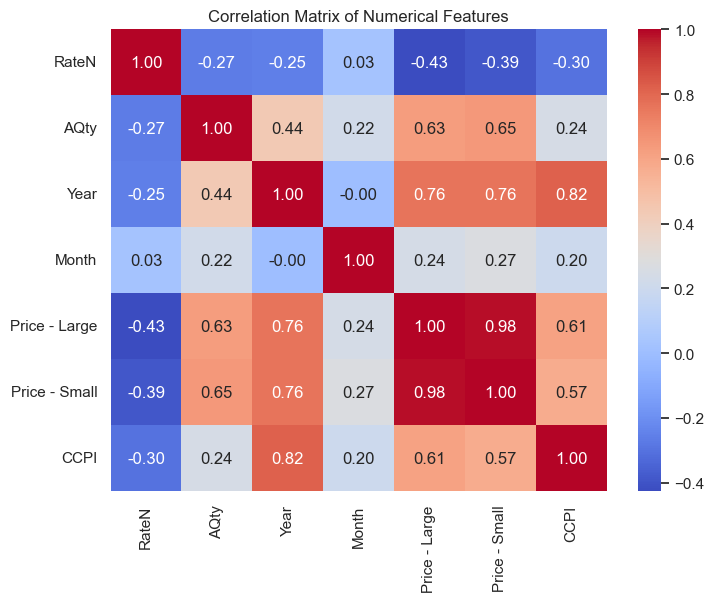

In [392]:
print("\nCorrelation Matrix:")
corr_matrix = final_df.corr(numeric_only=True)  
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [393]:
final_df = final_df.drop(["Price - Large"], axis=1) #high correlation feature drop (since the factors are similiar)
final_df

,Date,RateN,AQty,Year,Month,Price - Small,CCPI
0,2021-01-01,800.0,87,2021,1,85.0,119.9
1,2021-01-02,802.5,103,2021,1,85.0,119.9
2,2021-01-03,799.8,93,2021,1,85.0,119.9
3,2021-01-04,797.2,97,2021,1,85.0,119.9
4,2021-01-05,794.9,116,2021,1,85.0,119.9
...,...,...,...,...,...,...,...
1456,2024-12-27,772.2,200,2024,12,155.5,240.7
1457,2024-12-28,773.7,200,2024,12,155.5,240.7
1458,2024-12-29,775.2,200,2024,12,155.5,240.7
1459,2024-12-30,776.7,200,2024,12,155.5,240.7


In [394]:
#formatting
final_df.rename(columns={'AQty': 'Qty'}, inplace=True)
final_df['Qty'] = final_df['Qty'].astype(int)

df1=final_df
print(df1.info())
print(df1.describe())
df1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1461 non-null   datetime64[ns]
 1   RateN          1461 non-null   float64       
 2   Qty            1461 non-null   int32         
 3   Year           1461 non-null   int64         
 4   Month          1461 non-null   int64         
 5   Price - Small  1461 non-null   float64       
 6   CCPI           1461 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2)
memory usage: 74.3 KB
None
                                Date        RateN          Qty         Year  \
count                           1461  1461.000000  1461.000000  1461.000000   
mean   2023-01-01 00:00:00.000000256   827.898357   121.170431  2022.501027   
min              2021-01-01 00:00:00   704.700000    18.000000  2021.000000   
25%              2022-01-01 00:00:

,Date,RateN,Qty,Year,Month,Price - Small,CCPI
0,2021-01-01,800.0,87,2021,1,85.0,119.9
1,2021-01-02,802.5,103,2021,1,85.0,119.9
2,2021-01-03,799.8,93,2021,1,85.0,119.9
3,2021-01-04,797.2,97,2021,1,85.0,119.9
4,2021-01-05,794.9,116,2021,1,85.0,119.9
...,...,...,...,...,...,...,...
1456,2024-12-27,772.2,200,2024,12,155.5,240.7
1457,2024-12-28,773.7,200,2024,12,155.5,240.7
1458,2024-12-29,775.2,200,2024,12,155.5,240.7
1459,2024-12-30,776.7,200,2024,12,155.5,240.7


# EDA

In [395]:
df1=final_df

In [396]:
#stationary checking
result = adfuller(df1['Qty'])

# Extract ADF test results
adf_stat = result[0]
p_value = result[1]
used_lag = result[2]
n_obs = result[3]
critical_values = result[4]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")
print(f"# Lags Used: {used_lag}")
print(f"# Observations Used: {n_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpretation
if p_value < 0.05:
    print("\nConclusion: The series is likely stationary (reject H0).")
else:
    print("\nConclusion: The series is likely non-stationary (fail to reject H0).")

ADF Statistic: -3.036804235036614
p-value: 0.03159738527119248
# Lags Used: 10
# Observations Used: 1450
Critical Values:
   1%: -3.4348678719530934
   5%: -2.863535337271721
   10%: -2.5678323015457787

Conclusion: The series is likely stationary (reject H0).


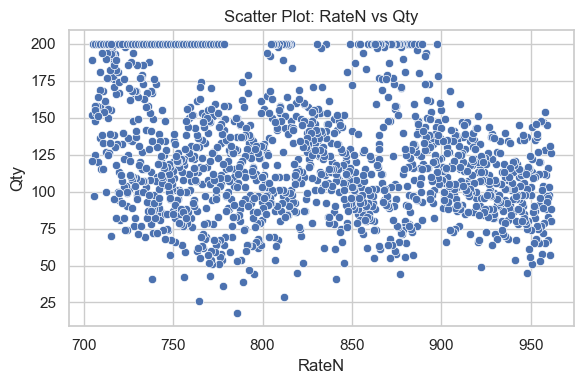

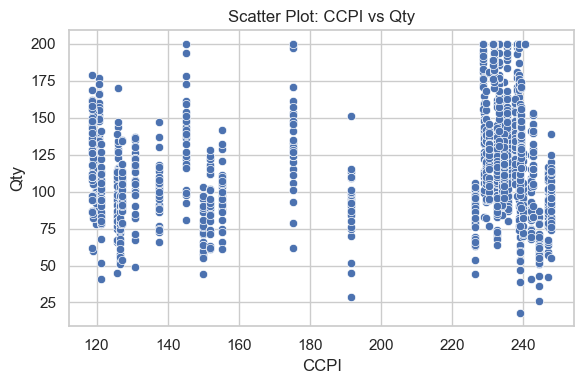

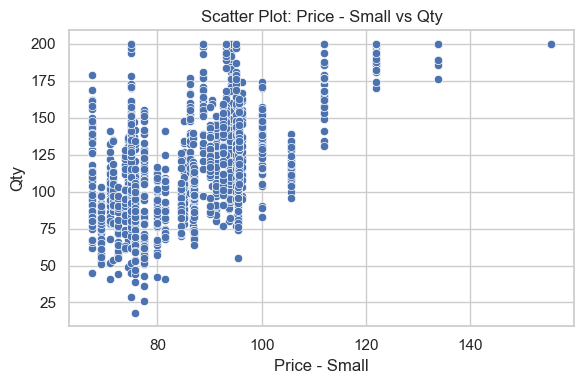

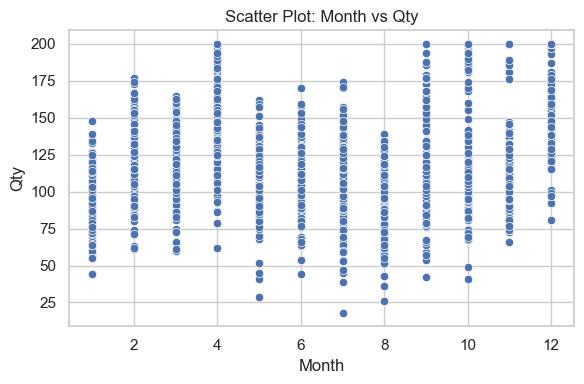

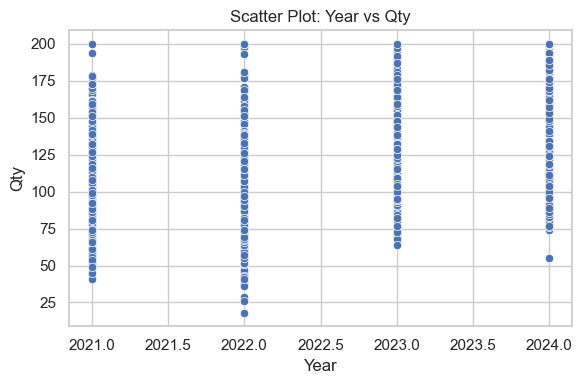

In [397]:
#plot scatter plots
sns.set(style="whitegrid")

target = 'Qty'
features = ['RateN', 'CCPI','Price - Small', 'Month', 'Year'] 

for col in features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df1, x=col, y=target)
    plt.title(f'Scatter Plot: {col} vs {target}')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()


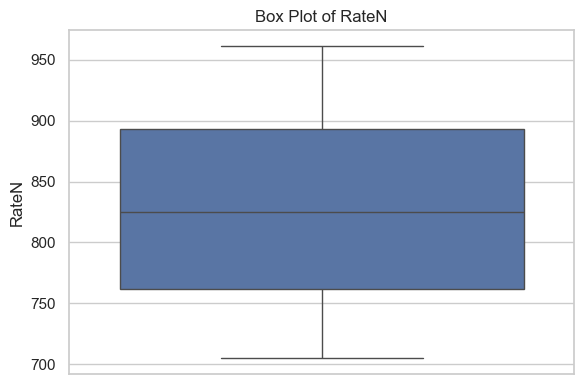

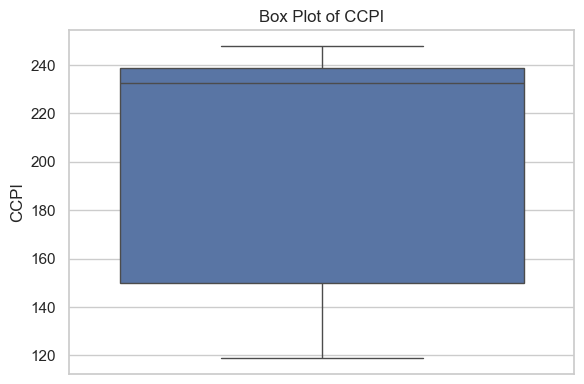

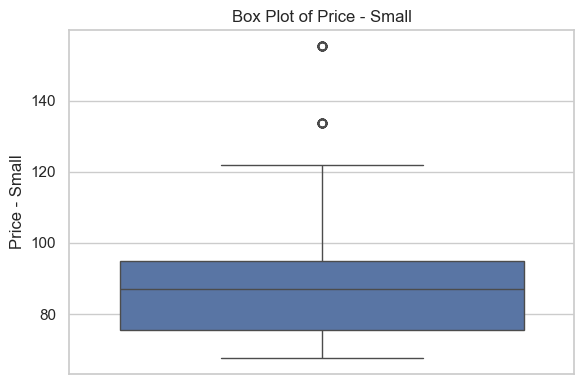

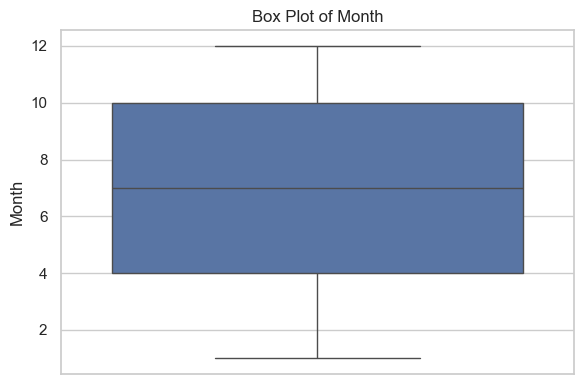

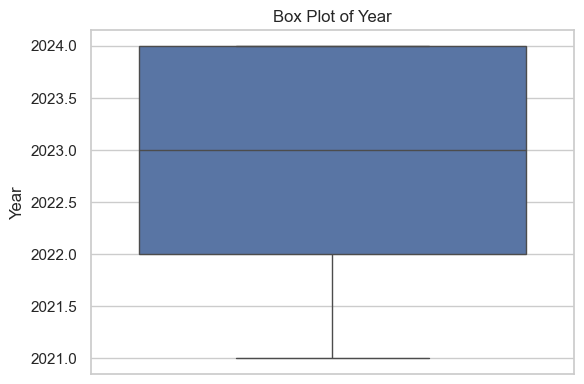

In [398]:
# Create box plots
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df1, y=col)
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

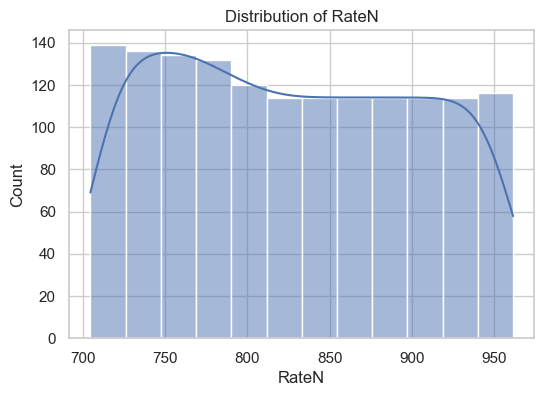

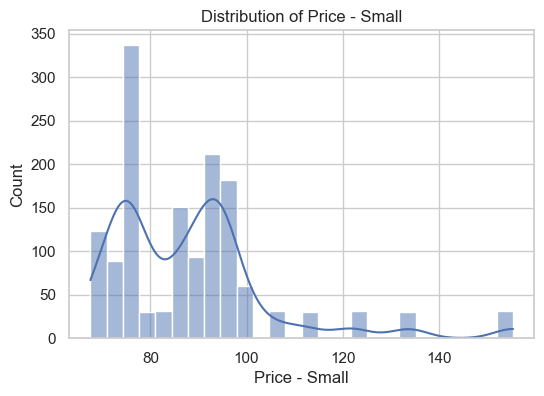

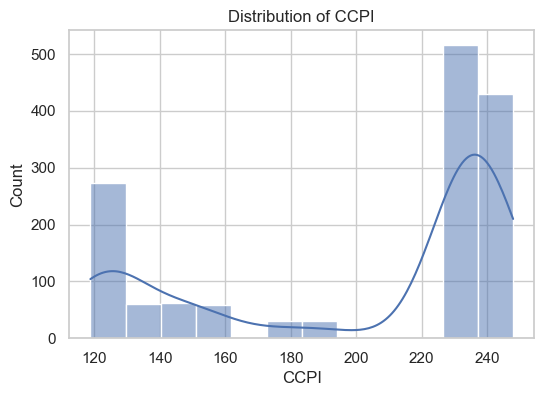

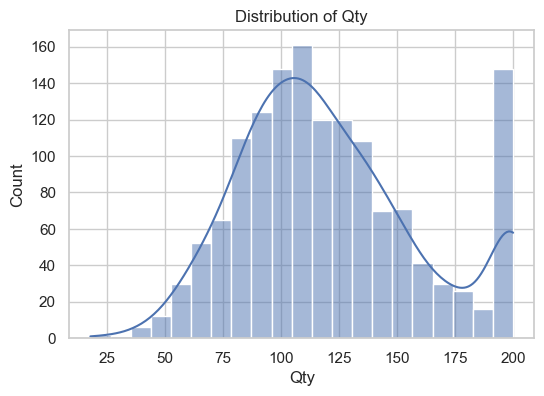

In [399]:
#Plot distribution using histograms with KDE (Kernel Density Estimation) curves
numeric_cols = ['RateN', 'Price - Small',  'CCPI', 'Qty']
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df1[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


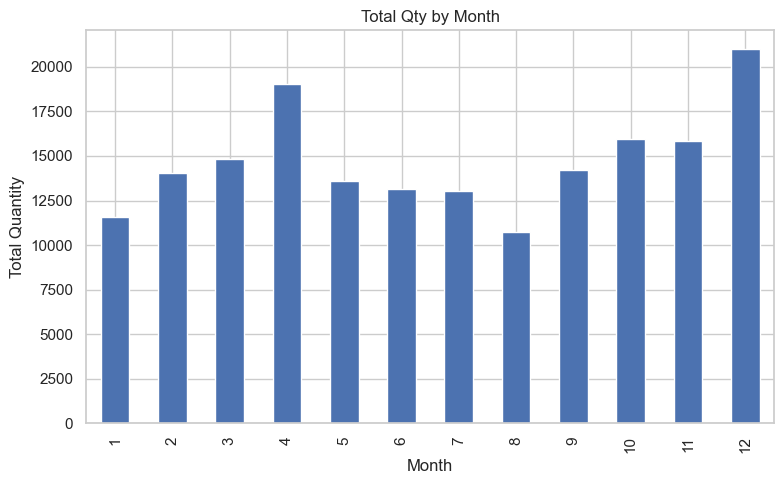

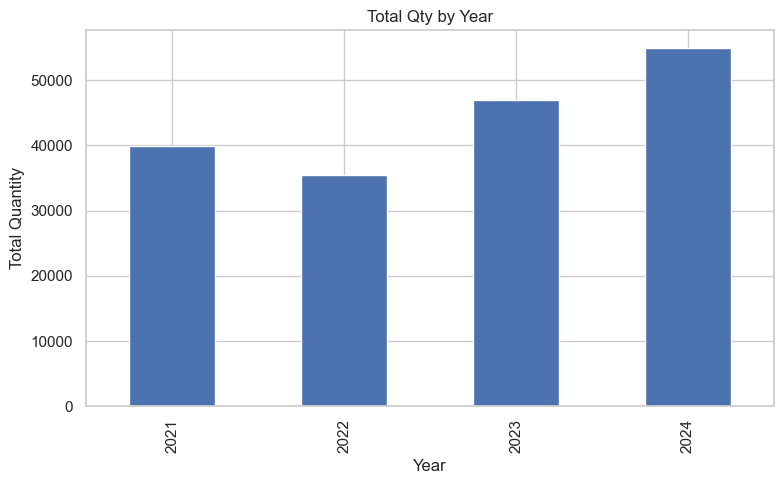

In [400]:
# Total Qty by Month
plt.figure(figsize=(8, 5))
df1.groupby('Month')['Qty'].sum().plot(kind='bar')
plt.title('Total Qty by Month')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.tight_layout()
plt.show()

# Total Qty by Year
plt.figure(figsize=(8, 5))
df1.groupby('Year')['Qty'].sum().plot(kind='bar')
plt.title('Total Qty by Year')
plt.xlabel('Year')
plt.ylabel('Total Quantity')
plt.tight_layout()
plt.show()

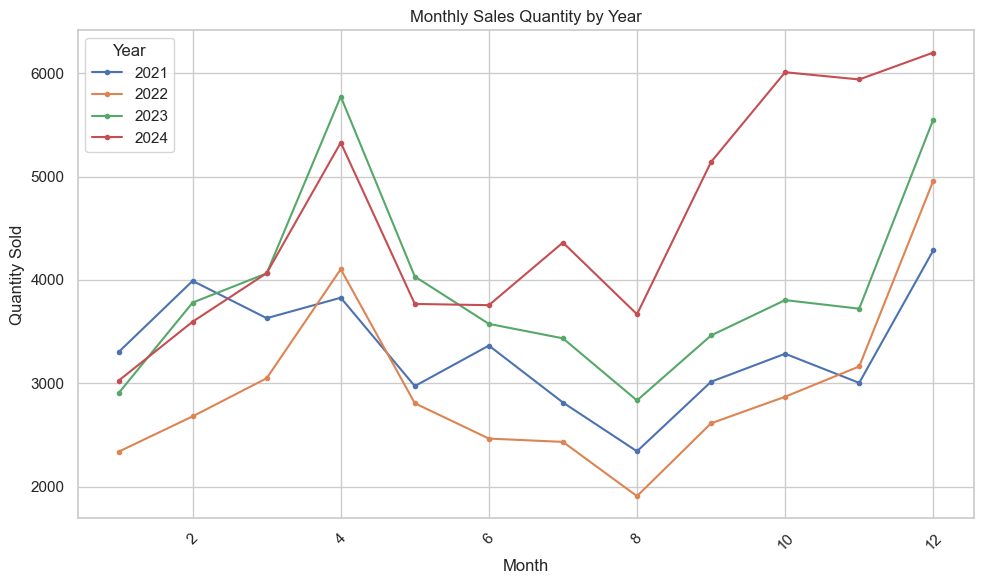

In [401]:
#Monthly sales qty over months by year
pivot_df = final_df.pivot_table(
    index='Month',
    columns='Year',
    values='Qty',
    aggfunc='sum'  # or 'mean' depending on your use case
)


# Plotting
pivot_df.plot(kind='line', marker='.', figsize=(10, 6))
plt.title('Monthly Sales Quantity by Year')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Model building

In [402]:
data = df1

In [403]:
# Prepare exogenous variables
def prepare_exogenous(data, future_dates):
    future_data = pd.DataFrame({'Date': future_dates})
    future_data['RateN'] = data['RateN'].iloc[-1]
    future_data['Price - Small'] = data['Price - Small'].iloc[-1]
    future_data['CCPI'] = data['CCPI'].iloc[-1]
    future_data['Year'] = future_data['Date'].dt.year
    future_data['Month'] = future_data['Date'].dt.month
    return future_data[['RateN', 'Price - Small', 'CCPI']]

In [404]:
# Split into train and test (2024 as test set)
train = data[data['Date'] < '2024-01-01']
test = data[data['Date'] >= '2024-01-01']

# Prepare exogenous variables
exog = train[['RateN', 'Price - Small', 'CCPI']]
exog_test = test[['RateN', 'Price - Small', 'CCPI']]
future_dates = pd.date_range(start='2025-01-01', end='2025-03-31', freq='D')
exog_future = prepare_exogenous(data, future_dates)

# Fit auto_arima to find optimal parameters
model = auto_arima(
    train['Qty'],
    exogenous=exog,
    seasonal=True,
    m=30,  # Monthly seasonality
    max_p=3, max_q=3, max_P=2, max_Q=2,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=23.15 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=10489.642, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=10234.429, Time=1.54 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=10011.763, Time=3.39 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=10487.655, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=10010.068, Time=0.35 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=10011.724, Time=2.29 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=15.21 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=10011.522, Time=0.70 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=10011.485, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=10233.303, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=10003.962, Time=1.57 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=10005.738, Time=24.38 sec
 ARIMA(1,1,2)(0,0,1)[30] intercept   : AIC=10005.763, Time=25.11 sec
 ARIMA(1,1,2)

In [405]:
# Fit SARIMAX with optimal parameters
sarimax_model = SARIMAX(
    train['Qty'],
    exog=exog,
    order=model.order,
    seasonal_order=model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = sarimax_model.fit(disp=False, maxiter=100)

# Model Evaluation

In [406]:
# Evaluate on train set
print("Train Set Evaluation:")
train_predictions = results.predict(start=train.index[0], end=train.index[-1], exog=exog)
train_predictions = train_predictions.round().astype(int)
train_rmse = np.sqrt(mean_squared_error(train['Qty'], train_predictions))
train_mae = mean_absolute_error(train['Qty'], train_predictions)
train_r2 = r2_score(train['Qty'], train_predictions)
print(f"RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.2f}")

# Evaluate on test set
print("Test Set Evaluation:")
predictions = results.predict(start=test.index[0], end=test.index[-1], exog=exog_test)
predictions = np.clip(predictions, 0, 200).round().astype(int)
rmse = np.sqrt(mean_squared_error(test['Qty'], predictions))
mae = mean_absolute_error(test['Qty'], predictions)
r2 = r2_score(test['Qty'], predictions)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

Train Set Evaluation:
RMSE: 22.97, MAE: 18.09, R²: 0.56
Test Set Evaluation:
RMSE: 55.45, MAE: 44.38, R²: -1.13


In [407]:
print(results.summary()) #to check feature significance

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                 1095
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -4969.721
Date:                Wed, 02 Jul 2025   AIC                           9953.441
Time:                        23:45:17   BIC                           9988.405
Sample:                             0   HQIC                          9966.674
                               - 1095                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
RateN            -0.1856      0.156     -1.187      0.235      -0.492       0.121
Price - Small     3.1744      0.622      5.105      0.000       1.956       4.393
CCPI             -0.3268      0.268     

# Forecast

In [409]:
# Forecast
forecast = results.forecast(steps=len(future_dates), exog=exog_future)
forecast = forecast.round().astype(int)

# Create output DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Qty': forecast
})

forecast_df.to_csv('forecasted_sales_qty_2025_sarimax.csv', index=False)
print("Forecast Sample:")
print(forecast_df.head())
print(forecast_df.tail())

Forecast Sample:
           Date  Forecasted_Qty
1095 2025-01-01             388
1096 2025-01-02             385
1097 2025-01-03             388
1098 2025-01-04             386
1099 2025-01-05             388
           Date  Forecasted_Qty
1180 2025-03-27             387
1181 2025-03-28             387
1182 2025-03-29             387
1183 2025-03-30             387
1184 2025-03-31             387


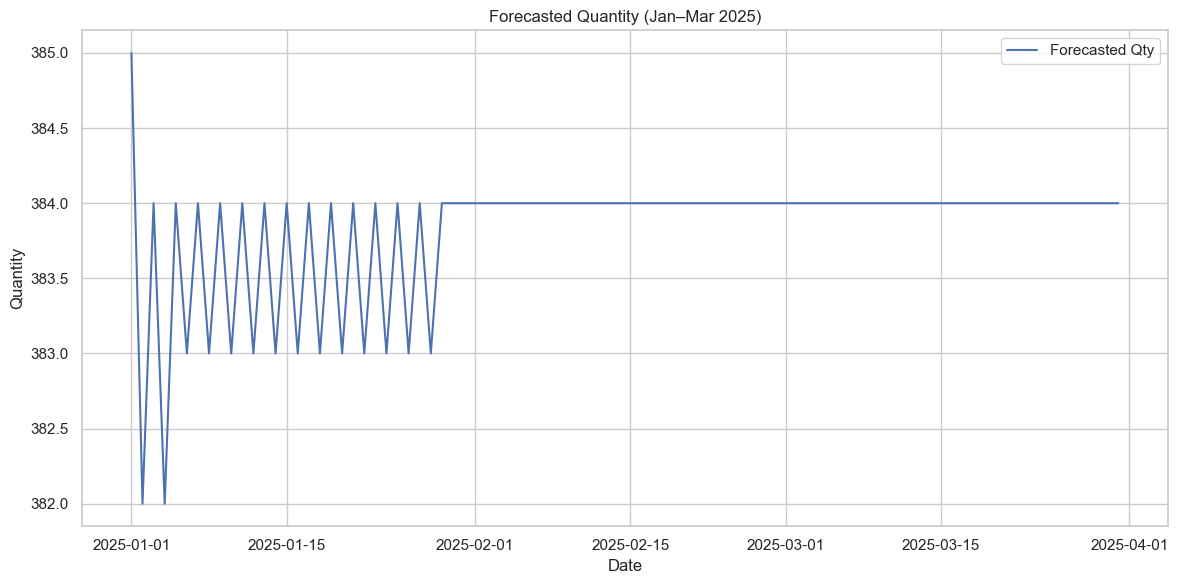

In [341]:
#plot forecasted output
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Qty'], label='Forecasted Qty')
plt.title('Forecasted Quantity (Jan–Mar 2025)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()